In [1]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# custom modules
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining
from src.model_building.eval_model import ModelEvaluator
from src.utils import *
from config.paths import *

In [3]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 
build_model = ModelTraining(PROJECT_PATH)

In [4]:
market_type = 'rtm'

### Data Ingestion

In [5]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

dam data is already updated up to:  2024-01-16 23:45:00
rtm data updated up to:  16-01-2024 17:45


In [6]:
weather = load_pickle(PROCESSED_DATA_PATH, 'weather_data')
wind = load_pickle(PROCESSED_DATA_PATH, 'wind_data')
hydro = load_pickle(PROCESSED_DATA_PATH, 'hydro_data')
solar = load_pickle(PROCESSED_DATA_PATH, 'solar_data')

In [7]:
rtm = rtm[rtm['datetime'] < datetime.now().strftime('%Y-%m-%d')]

### Feature Engineering

In [8]:
dam = featured_data.shift_date(dam, 1) 
weather = featured_data.shift_date(weather, 2)
hydro = featured_data.shift_date(hydro, 2) 
solar = featured_data.shift_date(solar, 2) 
wind = featured_data.shift_date(wind, 2)

data = featured_data.merge_dataframes([rtm, dam, weather, hydro, solar, wind])

In [9]:
training_data = featured_data._get_features(data, weather, market_type)

In [10]:
save_pickle(training_data, PROCESSED_DATA_PATH, f'{market_type}_training_data')

In [11]:
training_data

,datetime,mcp_rtm,clearedvolume_rtm,pb_rtm,sb_rtm,diff_sb_pb_rtm,mcp_dam,clearedvolume_dam,pb_dam,sb_dam,...,mcp_rtm_with_rh_pat,mcp_rtm_with_prec_pat,mcp_rtm_with_temp_ran,mcp_rtm_with_atemp_ran,mcp_rtm_with_rh_ran,mcp_rtm_with_prec_ran,mcp_rtm_with_temp_guw,mcp_rtm_with_atemp_guw,mcp_rtm_with_rh_guw,mcp_rtm_with_prec_guw
0,2020-07-09 00:00:00,3056.12,1530.5,2314.4,2466.9,-152.5,2005.55,5745.60,6779.8,9676.3,...,287509.632587,2017.786314,73273.013824,76385.133846,300236.999517,4448.008172,80634.450331,90065.183337,296246.943319,13139.678610
1,2020-07-09 00:15:00,3000.00,1588.9,2246.6,2525.7,-279.1,2008.37,5502.20,6761.9,9830.0,...,282504.615787,1711.992503,71998.168950,75059.337607,294690.490718,6164.719105,79704.345705,90005.973825,288674.480445,11966.624738
2,2020-07-09 00:30:00,3001.28,1569.0,2070.3,2472.4,-402.1,2008.44,5394.20,6659.1,9985.0,...,282899.834891,1443.867397,72099.597035,75168.271408,294783.000399,7966.507086,80289.185959,91639.728022,286664.303539,11039.565003
3,2020-07-09 00:45:00,2949.92,1274.8,1727.4,2411.4,-684.0,2008.30,5296.20,6549.9,10141.0,...,278367.635956,2049.211671,70819.595839,73837.384390,289977.561356,7226.231232,78620.098787,89234.347159,282995.847348,9715.759698
4,2020-07-09 01:00:00,2800.36,927.8,1267.2,2420.0,-1152.8,2007.05,5104.60,6261.6,10251.5,...,264547.801340,2543.426564,67185.223908,70051.556511,275502.763412,6286.536142,74353.925021,83915.461142,269822.469293,8145.823721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123141,2024-01-13 22:45:00,4776.65,4595.1,6278.1,6753.2,-475.1,3224.73,5935.50,9424.0,15910.5,...,417956.875000,0.000000,63278.670875,52961.106875,298540.625000,0.000000,76426.400000,82444.979000,477665.000000,0.000000
123142,2024-01-13 23:00:00,4211.48,4197.8,6166.9,7413.1,-1246.2,3160.38,6112.77,9693.6,16877.0,...,370610.240000,0.000000,55444.134200,46389.452200,265323.240000,0.000000,67383.680000,72732.259600,421148.000000,0.000000
123143,2024-01-13 23:15:00,4014.84,3952.5,5924.4,7524.3,-1599.9,3142.08,6115.90,9539.9,17534.4,...,355313.340000,0.000000,52524.144300,43932.386700,254942.340000,0.000000,64237.440000,69376.435200,401484.000000,0.000000
123144,2024-01-13 23:30:00,4219.63,4245.2,6206.7,7298.6,-1091.9,3130.16,5977.68,9350.9,17850.2,...,375547.070000,0.000000,54855.190000,45867.378100,270056.320000,0.000000,67514.080000,72957.402700,421963.000000,0.000000


### Model Building

In [12]:
training_data = load_pickle(PROCESSED_DATA_PATH, f'{market_type}_training_data')

In [16]:
# trail and error
n_trials = 50
n_features = 25

In [17]:
best_features, best_params = build_model._features_n_params(training_data, n_trials, n_features)

[I 2024-01-16 17:11:55,168] A new study created in memory with name: no-name-85705720-9d2b-4276-8e47-4800ae04056a
[I 2024-01-16 17:11:55,540] Trial 0 finished with value: 1.261345818651464e+18 and parameters: {'n_estimators': 300, 'lambda_l1': 55.0, 'lambda_l2': 45.0, 'num_leaves': 9050, 'min_data_in_leaf': 5300, 'max_bin': 252, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.3, 'bagging_freq': 1, 'min_gain_to_split': 10.02418580684805, 'max_depth': 6, 'learning_rate': 0.11}. Best is trial 0 with value: 1.261345818651464e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=2.3030036897445196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3030036897445196
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-16 17:11:55,869] Trial 1 finished with value: 1.2459659660360435e+18 and parameters: {'n_estimators': 100, 'lambda_l1': 25.0, 'lambda_l2': 80.0, 'num_leaves': 4200, 'min_data_in_leaf': 6200, 'max_bin': 226, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 7, 'min_gain_to_split': 2.3030036897445196, 'max_depth': 8, 'learning_rate': 0.13}. Best is trial 1 with value: 1.2459659660360435e+18.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=12.037559554100415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.037559554100415
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 17:11:56,130] Trial 2 finished with value: 1.329054207572289e+18 and parameters: {'n_estimators': 600, 'lambda_l1': 15.0, 'lambda_l2': 65.0, 'num_leaves': 200, 'min_data_in_leaf': 9300, 'max_bin': 266, 'feature_fraction': 0.7, 'bagging_fraction': 0.3, 'bagging_freq': 2, 'min_gain_to_split': 12.037559554100415, 'max_depth': 14, 'learning_rate': 0.28}. Best is trial 1 with value: 1.2459659660360435e+18.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=0.44342641984518205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44342641984518205
[LightGBM] [Warning] lambda_l1 is set=75.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75.0


[I 2024-01-16 17:11:56,404] Trial 3 finished with value: 1.2517482511188042e+18 and parameters: {'n_estimators': 300, 'lambda_l1': 75.0, 'lambda_l2': 5.0, 'num_leaves': 4850, 'min_data_in_leaf': 8200, 'max_bin': 262, 'feature_fraction': 0.4, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'min_gain_to_split': 0.44342641984518205, 'max_depth': 9, 'learning_rate': 0.06999999999999999}. Best is trial 1 with value: 1.2459659660360435e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] lambda_l2 is set=85.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=11.357853931701312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.357853931701312
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-16 17:11:56,684] Trial 4 finished with value: 1.2602545159280448e+18 and parameters: {'n_estimators': 600, 'lambda_l1': 25.0, 'lambda_l2': 85.0, 'num_leaves': 2850, 'min_data_in_leaf': 9100, 'max_bin': 265, 'feature_fraction': 0.3, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 5, 'min_gain_to_split': 11.357853931701312, 'max_depth': 7, 'learning_rate': 0.29000000000000004}. Best is trial 1 with value: 1.2459659660360435e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=5.031072147368128, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.031072147368128
[LightGBM] [Warning] lambda_l1 is set=45.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45.0


[I 2024-01-16 17:11:57,242] Trial 5 finished with value: 1.2548908654264817e+18 and parameters: {'n_estimators': 200, 'lambda_l1': 45.0, 'lambda_l2': 15.0, 'num_leaves': 6100, 'min_data_in_leaf': 300, 'max_bin': 300, 'feature_fraction': 0.5, 'bagging_fraction': 0.5, 'bagging_freq': 6, 'min_gain_to_split': 5.031072147368128, 'max_depth': 14, 'learning_rate': 0.18000000000000002}. Best is trial 1 with value: 1.2459659660360435e+18.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=6.0079329945999325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.0079329945999325
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 17:11:57,558] Trial 6 finished with value: 1.2395525894839058e+18 and parameters: {'n_estimators': 500, 'lambda_l1': 5.0, 'lambda_l2': 55.0, 'num_leaves': 5400, 'min_data_in_leaf': 800, 'max_bin': 297, 'feature_fraction': 0.7, 'bagging_fraction': 0.4, 'bagging_freq': 3, 'min_gain_to_split': 6.0079329945999325, 'max_depth': 7, 'learning_rate': 0.21000000000000002}. Best is trial 6 with value: 1.2395525894839058e+18.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] lambda_l2 is set=60.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=3.314061081520738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.314061081520738
[LightGBM] [Warning] lambda_l1 is set=50.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50.0


[I 2024-01-16 17:11:57,834] Trial 7 finished with value: 1.2471571252814812e+18 and parameters: {'n_estimators': 400, 'lambda_l1': 50.0, 'lambda_l2': 60.0, 'num_leaves': 3600, 'min_data_in_leaf': 3200, 'max_bin': 230, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 3, 'min_gain_to_split': 3.314061081520738, 'max_depth': 5, 'learning_rate': 0.26}. Best is trial 6 with value: 1.2395525894839058e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=7.762733153240677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.762733153240677
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0


[I 2024-01-16 17:11:58,155] Trial 8 finished with value: 1.222838626674225e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 5.0, 'lambda_l2': 50.0, 'num_leaves': 8250, 'min_data_in_leaf': 1600, 'max_bin': 286, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 7.762733153240677, 'max_depth': 9, 'learning_rate': 0.26}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l2 is set=80.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=1.7307596743663773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7307596743663773
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:11:58,454] Trial 9 finished with value: 1.2283081143021606e+18 and parameters: {'n_estimators': 300, 'lambda_l1': 100.0, 'lambda_l2': 80.0, 'num_leaves': 6500, 'min_data_in_leaf': 1900, 'max_bin': 297, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'min_gain_to_split': 1.7307596743663773, 'max_depth': 10, 'learning_rate': 0.09999999999999999}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=7.977532774518262, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.977532774518262
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


[I 2024-01-16 17:11:58,823] Trial 10 finished with value: 1.2304478723935437e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 0.0, 'lambda_l2': 35.0, 'num_leaves': 9800, 'min_data_in_leaf': 3100, 'max_bin': 204, 'feature_fraction': 1.0, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 7.977532774518262, 'max_depth': 3, 'learning_rate': 0.03}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] lambda_l2 is set=95.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.578008960921363, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.578008960921363
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:11:59,248] Trial 11 finished with value: 1.2333395688000755e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 100.0, 'lambda_l2': 95.0, 'num_leaves': 7550, 'min_data_in_leaf': 2500, 'max_bin': 284, 'feature_fraction': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 7, 'min_gain_to_split': 8.578008960921363, 'max_depth': 12, 'learning_rate': 0.22}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.848668512493752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.848668512493752
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:11:59,840] Trial 12 finished with value: 1.2254133082239288e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 100.0, 'lambda_l2': 30.0, 'num_leaves': 7700, 'min_data_in_leaf': 1800, 'max_bin': 282, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 4, 'min_gain_to_split': 14.848668512493752, 'max_depth': 10, 'learning_rate': 0.09}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=4300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4300
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.98364991571511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.98364991571511
[LightGBM] [Warning] lambda_l1 is set=75.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75.0


[I 2024-01-16 17:12:00,300] Trial 13 finished with value: 1.2283279480727562e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 75.0, 'lambda_l2': 30.0, 'num_leaves': 8050, 'min_data_in_leaf': 4300, 'max_bin': 281, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'bagging_freq': 4, 'min_gain_to_split': 14.98364991571511, 'max_depth': 11, 'learning_rate': 0.02}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=12.951031826069752, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.951031826069752
[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0


[I 2024-01-16 17:12:01,031] Trial 14 finished with value: 1.2346600045533524e+18 and parameters: {'n_estimators': 1000, 'lambda_l1': 80.0, 'lambda_l2': 25.0, 'num_leaves': 7900, 'min_data_in_leaf': 1600, 'max_bin': 277, 'feature_fraction': 0.8, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 12.951031826069752, 'max_depth': 12, 'learning_rate': 0.16}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.590812358582665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.590812358582665
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-16 17:12:01,421] Trial 15 finished with value: 1.231482545895004e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 35.0, 'lambda_l2': 45.0, 'num_leaves': 10000, 'min_data_in_leaf': 6800, 'max_bin': 243, 'feature_fraction': 0.3, 'bagging_fraction': 0.8, 'bagging_freq': 4, 'min_gain_to_split': 14.590812358582665, 'max_depth': 10, 'learning_rate': 0.060000000000000005}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] lambda_l2 is set=15.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=9.607775655903453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.607775655903453
[LightGBM] [Warning] lambda_l1 is set=65.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65.0


[I 2024-01-16 17:12:01,833] Trial 16 finished with value: 1.230849061264669e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 65.0, 'lambda_l2': 15.0, 'num_leaves': 6800, 'min_data_in_leaf': 4400, 'max_bin': 285, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 9.607775655903453, 'max_depth': 9, 'learning_rate': 0.22}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.920574865433164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.920574865433164
[LightGBM] [Warning] lambda_l1 is set=90.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90.0


[I 2024-01-16 17:12:02,603] Trial 17 finished with value: 1.2262137902083039e+18 and parameters: {'n_estimators': 1000, 'lambda_l1': 90.0, 'lambda_l2': 0.0, 'num_leaves': 8800, 'min_data_in_leaf': 1300, 'max_bin': 273, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 5.920574865433164, 'max_depth': 15, 'learning_rate': 0.25}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=12.919323497505275, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.919323497505275
[LightGBM] [Warning] lambda_l1 is set=40.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40.0


[I 2024-01-16 17:12:03,030] Trial 18 finished with value: 1.2391806471649743e+18 and parameters: {'n_estimators': 500, 'lambda_l1': 40.0, 'lambda_l2': 40.0, 'num_leaves': 1450, 'min_data_in_leaf': 3500, 'max_bin': 257, 'feature_fraction': 0.4, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 3, 'min_gain_to_split': 12.919323497505275, 'max_depth': 4, 'learning_rate': 0.14}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=6.845272781965525, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.845272781965525
[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0


[I 2024-01-16 17:12:03,487] Trial 19 finished with value: 1.2456036780907528e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 60.0, 'lambda_l2': 70.0, 'num_leaves': 7100, 'min_data_in_leaf': 2400, 'max_bin': 243, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 4, 'min_gain_to_split': 6.845272781965525, 'max_depth': 12, 'learning_rate': 0.19}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=20.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=4.239155279348552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.239155279348552
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 17:12:03,989] Trial 20 finished with value: 1.232375660516728e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 15.0, 'lambda_l2': 20.0, 'num_leaves': 8900, 'min_data_in_leaf': 500, 'max_bin': 292, 'feature_fraction': 0.4, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 5, 'min_gain_to_split': 4.239155279348552, 'max_depth': 8, 'learning_rate': 0.08}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.970564173457857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.970564173457857
[LightGBM] [Warning] lambda_l1 is set=90.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90.0


[I 2024-01-16 17:12:04,646] Trial 21 finished with value: 1.2296213340581015e+18 and parameters: {'n_estimators': 1000, 'lambda_l1': 90.0, 'lambda_l2': 0.0, 'num_leaves': 8500, 'min_data_in_leaf': 1100, 'max_bin': 272, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 5.970564173457857, 'max_depth': 15, 'learning_rate': 0.25}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=9.76610937651104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.76610937651104
[LightGBM] [Warning] lambda_l1 is set=90.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90.0


[I 2024-01-16 17:12:05,384] Trial 22 finished with value: 1.2291154604595955e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 90.0, 'lambda_l2': 5.0, 'num_leaves': 9150, 'min_data_in_leaf': 1400, 'max_bin': 274, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 9.76610937651104, 'max_depth': 13, 'learning_rate': 0.3}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=6.901470147301253, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.901470147301253
[LightGBM] [Warning] lambda_l1 is set=90.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90.0


[I 2024-01-16 17:12:05,929] Trial 23 finished with value: 1.2539961668575923e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 90.0, 'lambda_l2': 50.0, 'num_leaves': 6050, 'min_data_in_leaf': 2300, 'max_bin': 288, 'feature_fraction': 0.7, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 6.901470147301253, 'max_depth': 15, 'learning_rate': 0.25}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=4.494721769375809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.494721769375809
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0


[I 2024-01-16 17:12:06,548] Trial 24 finished with value: 1.2732914666829174e+18 and parameters: {'n_estimators': 600, 'lambda_l1': 70.0, 'lambda_l2': 30.0, 'num_leaves': 7850, 'min_data_in_leaf': 200, 'max_bin': 271, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 4.494721769375809, 'max_depth': 10, 'learning_rate': 0.27}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8.477953425619212, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.477953425619212
[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0


[I 2024-01-16 17:12:07,004] Trial 25 finished with value: 1.257251298390889e+18 and parameters: {'n_estimators': 1000, 'lambda_l1': 85.0, 'lambda_l2': 10.0, 'num_leaves': 9400, 'min_data_in_leaf': 4200, 'max_bin': 290, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 8.477953425619212, 'max_depth': 11, 'learning_rate': 0.24000000000000002}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.977003244128586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.977003244128586
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:12:07,449] Trial 26 finished with value: 1.2267601717193367e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 100.0, 'lambda_l2': 35.0, 'num_leaves': 8550, 'min_data_in_leaf': 1400, 'max_bin': 279, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'min_gain_to_split': 10.977003244128586, 'max_depth': 6, 'learning_rate': 0.17}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] lambda_l2 is set=20.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=0.02087354132745034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02087354132745034
[LightGBM] [Warning] lambda_l1 is set=95.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95.0


[I 2024-01-16 17:12:07,953] Trial 27 finished with value: 1.231461955721233e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 95.0, 'lambda_l2': 20.0, 'num_leaves': 7500, 'min_data_in_leaf': 2800, 'max_bin': 260, 'feature_fraction': 0.5, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 4, 'min_gain_to_split': 0.02087354132745034, 'max_depth': 13, 'learning_rate': 0.2}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=13.685211348884796, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.685211348884796
[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0


[I 2024-01-16 17:12:08,374] Trial 28 finished with value: 1.2325293782920978e+18 and parameters: {'n_estimators': 500, 'lambda_l1': 80.0, 'lambda_l2': 55.0, 'num_leaves': 5500, 'min_data_in_leaf': 3700, 'max_bin': 269, 'feature_fraction': 1.0, 'bagging_fraction': 0.7, 'bagging_freq': 2, 'min_gain_to_split': 13.685211348884796, 'max_depth': 9, 'learning_rate': 0.04}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=3.209732354039823, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.209732354039823
[LightGBM] [Warning] lambda_l1 is set=60.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60.0


[I 2024-01-16 17:12:08,770] Trial 29 finished with value: 1.2279063453207104e+18 and parameters: {'n_estimators': 400, 'lambda_l1': 60.0, 'lambda_l2': 45.0, 'num_leaves': 8400, 'min_data_in_leaf': 6600, 'max_bin': 254, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'min_gain_to_split': 3.209732354039823, 'max_depth': 6, 'learning_rate': 0.12}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] lambda_l2 is set=70.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.619055497261662, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.619055497261662
[LightGBM] [Warning] lambda_l1 is set=55.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55.0


[I 2024-01-16 17:12:09,184] Trial 30 finished with value: 1.2460142526517266e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 55.0, 'lambda_l2': 70.0, 'num_leaves': 7000, 'min_data_in_leaf': 4800, 'max_bin': 249, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 10.619055497261662, 'max_depth': 8, 'learning_rate': 0.09}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=9.119336457609506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.119336457609506
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:12:09,623] Trial 31 finished with value: 1.2349790465502292e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 100.0, 'lambda_l2': 35.0, 'num_leaves': 8800, 'min_data_in_leaf': 1500, 'max_bin': 279, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'min_gain_to_split': 9.119336457609506, 'max_depth': 5, 'learning_rate': 0.16}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=11.275155071985028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.275155071985028
[LightGBM] [Warning] lambda_l1 is set=95.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95.0


[I 2024-01-16 17:12:10,075] Trial 32 finished with value: 1.24879735558784e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 95.0, 'lambda_l2': 40.0, 'num_leaves': 9450, 'min_data_in_leaf': 5600, 'max_bin': 281, 'feature_fraction': 0.8, 'bagging_fraction': 0.7, 'bagging_freq': 7, 'min_gain_to_split': 11.275155071985028, 'max_depth': 6, 'learning_rate': 0.18000000000000002}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l2 is set=50.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.0
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=7.41620469008012, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.41620469008012
[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0


[I 2024-01-16 17:12:10,549] Trial 33 finished with value: 1.242508774023077e+18 and parameters: {'n_estimators': 600, 'lambda_l1': 85.0, 'lambda_l2': 50.0, 'num_leaves': 8400, 'min_data_in_leaf': 1900, 'max_bin': 292, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 7.41620469008012, 'max_depth': 7, 'learning_rate': 0.23}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.158634688009764, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.158634688009764
[LightGBM] [Warning] lambda_l1 is set=25.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25.0


[I 2024-01-16 17:12:10,981] Trial 34 finished with value: 1.2285518071527324e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 25.0, 'lambda_l2': 25.0, 'num_leaves': 7400, 'min_data_in_leaf': 1000, 'max_bin': 275, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 12.158634688009764, 'max_depth': 4, 'learning_rate': 0.14}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.349919957856788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.349919957856788
[LightGBM] [Warning] lambda_l1 is set=95.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95.0


[I 2024-01-16 17:12:11,438] Trial 35 finished with value: 1.278563221901423e+18 and parameters: {'n_estimators': 600, 'lambda_l1': 95.0, 'lambda_l2': 0.0, 'num_leaves': 9050, 'min_data_in_leaf': 2200, 'max_bin': 265, 'feature_fraction': 0.7, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 10.349919957856788, 'max_depth': 11, 'learning_rate': 0.28}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[LightGBM] [Warning] lambda_l2 is set=65.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=5.884544633093014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.884544633093014
[LightGBM] [Warning] lambda_l1 is set=15.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15.0


[I 2024-01-16 17:12:12,023] Trial 36 finished with value: 1.2337844463101064e+18 and parameters: {'n_estimators': 100, 'lambda_l1': 15.0, 'lambda_l2': 65.0, 'num_leaves': 8200, 'min_data_in_leaf': 7800, 'max_bin': 285, 'feature_fraction': 0.8, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 6, 'min_gain_to_split': 5.884544633093014, 'max_depth': 14, 'learning_rate': 0.05}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=35.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=13.964717708555632, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.964717708555632
[LightGBM] [Warning] lambda_l1 is set=35.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35.0


[I 2024-01-16 17:12:12,509] Trial 37 finished with value: 1.2493699491257774e+18 and parameters: {'n_estimators': 400, 'lambda_l1': 35.0, 'lambda_l2': 35.0, 'num_leaves': 4400, 'min_data_in_leaf': 800, 'max_bin': 265, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 3, 'min_gain_to_split': 13.964717708555632, 'max_depth': 7, 'learning_rate': 0.17}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.059617577768055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.059617577768055
[LightGBM] [Warning] lambda_l1 is set=75.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75.0


[I 2024-01-16 17:12:12,941] Trial 38 finished with value: 1.2354848502893612e+18 and parameters: {'n_estimators': 700, 'lambda_l1': 75.0, 'lambda_l2': 10.0, 'num_leaves': 6250, 'min_data_in_leaf': 2900, 'max_bin': 300, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 4, 'min_gain_to_split': 12.059617577768055, 'max_depth': 8, 'learning_rate': 0.3}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] lambda_l2 is set=60.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=11.134257105312132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.134257105312132
[LightGBM] [Warning] lambda_l1 is set=85.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85.0


[I 2024-01-16 17:12:13,382] Trial 39 finished with value: 1.2317104713590467e+18 and parameters: {'n_estimators': 600, 'lambda_l1': 85.0, 'lambda_l2': 60.0, 'num_leaves': 9600, 'min_data_in_leaf': 1200, 'max_bin': 294, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 7, 'min_gain_to_split': 11.134257105312132, 'max_depth': 5, 'learning_rate': 0.11}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=5.086903268447956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.086903268447956
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:12:13,874] Trial 40 finished with value: 1.223790642247519e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 100.0, 'lambda_l2': 45.0, 'num_leaves': 2850, 'min_data_in_leaf': 600, 'max_bin': 233, 'feature_fraction': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 5, 'min_gain_to_split': 5.086903268447956, 'max_depth': 9, 'learning_rate': 0.27}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=45.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=4.983327961578483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.983327961578483
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:12:14,335] Trial 41 finished with value: 1.2330167121117668e+18 and parameters: {'n_estimators': 1000, 'lambda_l1': 100.0, 'lambda_l2': 45.0, 'num_leaves': 2250, 'min_data_in_leaf': 600, 'max_bin': 228, 'feature_fraction': 0.5, 'bagging_fraction': 0.7, 'bagging_freq': 5, 'min_gain_to_split': 4.983327961578483, 'max_depth': 9, 'learning_rate': 0.27}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=6.756668816957183, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.756668816957183
[LightGBM] [Warning] lambda_l1 is set=95.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95.0


[I 2024-01-16 17:12:14,757] Trial 42 finished with value: 1.2379351531078566e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 95.0, 'lambda_l2': 55.0, 'num_leaves': 750, 'min_data_in_leaf': 1900, 'max_bin': 220, 'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 6, 'min_gain_to_split': 6.756668816957183, 'max_depth': 8, 'learning_rate': 0.26}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=40.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=1.839730356717121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.839730356717121
[LightGBM] [Warning] lambda_l1 is set=100.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100.0


[I 2024-01-16 17:12:15,281] Trial 43 finished with value: 1.2297046033988723e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 100.0, 'lambda_l2': 40.0, 'num_leaves': 3150, 'min_data_in_leaf': 200, 'max_bin': 220, 'feature_fraction': 0.6000000000000001, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 5, 'min_gain_to_split': 1.839730356717121, 'max_depth': 10, 'learning_rate': 0.28}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] lambda_l2 is set=30.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.3, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3
[LightGBM] [Warning] min_gain_to_split is set=3.3549800297963728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3549800297963728
[LightGBM] [Warning] lambda_l1 is set=90.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90.0


[I 2024-01-16 17:12:15,697] Trial 44 finished with value: 1.231851292974351e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 90.0, 'lambda_l2': 30.0, 'num_leaves': 4150, 'min_data_in_leaf': 1800, 'max_bin': 234, 'feature_fraction': 0.5, 'bagging_fraction': 0.3, 'bagging_freq': 6, 'min_gain_to_split': 3.3549800297963728, 'max_depth': 9, 'learning_rate': 0.2}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] lambda_l2 is set=25.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=5.152047507112097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.152047507112097
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0


[I 2024-01-16 17:12:16,118] Trial 45 finished with value: 1.230357873485023e+18 and parameters: {'n_estimators': 1000, 'lambda_l1': 10.0, 'lambda_l2': 25.0, 'num_leaves': 1800, 'min_data_in_leaf': 1100, 'max_bin': 208, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 5, 'min_gain_to_split': 5.152047507112097, 'max_depth': 3, 'learning_rate': 0.01}. Best is trial 8 with value: 1.222838626674225e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.94882143078603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.94882143078603
[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0


[I 2024-01-16 17:12:16,685] Trial 46 finished with value: 1.2192087865403297e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 80.0, 'lambda_l2': 55.0, 'num_leaves': 5550, 'min_data_in_leaf': 800, 'max_bin': 240, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'bagging_freq': 4, 'min_gain_to_split': 7.94882143078603, 'max_depth': 13, 'learning_rate': 0.24000000000000002}. Best is trial 46 with value: 1.2192087865403297e+18.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=75.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] min_gain_to_split is set=7.977119032891956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.977119032891956
[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0


[I 2024-01-16 17:12:17,245] Trial 47 finished with value: 1.2245232474498086e+18 and parameters: {'n_estimators': 900, 'lambda_l1': 80.0, 'lambda_l2': 75.0, 'num_leaves': 5350, 'min_data_in_leaf': 700, 'max_bin': 236, 'feature_fraction': 0.5, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 4, 'min_gain_to_split': 7.977119032891956, 'max_depth': 14, 'learning_rate': 0.24000000000000002}. Best is trial 46 with value: 1.2192087865403297e+18.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=90.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=7.8164627693481705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.8164627693481705
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0


[I 2024-01-16 17:12:17,756] Trial 48 finished with value: 1.2218253896250074e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 70.0, 'lambda_l2': 90.0, 'num_leaves': 5350, 'min_data_in_leaf': 800, 'max_bin': 235, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 3, 'min_gain_to_split': 7.8164627693481705, 'max_depth': 13, 'learning_rate': 0.23}. Best is trial 46 with value: 1.2192087865403297e+18.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] lambda_l2 is set=100.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100.0
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_gain_to_split is set=7.8822081667744595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.8822081667744595
[LightGBM] [Warning] lambda_l1 is set=70.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70.0


[I 2024-01-16 17:12:18,256] Trial 49 finished with value: 1.329600160176896e+18 and parameters: {'n_estimators': 800, 'lambda_l1': 70.0, 'lambda_l2': 100.0, 'num_leaves': 5400, 'min_data_in_leaf': 600, 'max_bin': 236, 'feature_fraction': 0.3, 'bagging_fraction': 1.0, 'bagging_freq': 3, 'min_gain_to_split': 7.8822081667744595, 'max_depth': 13, 'learning_rate': 0.23}. Best is trial 46 with value: 1.2192087865403297e+18.




Best MAPE achieved:  1.2192087865403297e+18


### Model Training & Evaluation

In [18]:
n = 5   # number of days for which evaluation is reqd

In [19]:
# training upto this date
training_upto = training_data['datetime'][::96].iloc[-n].strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [22]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] lambda_l2 is set=55.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.94882143078603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.94882143078603
[LightGBM] [Warning] lambda_l1 is set=80.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80.0


In [23]:
if n > X_test[::96].shape[0]:
    n = X_test[::96].shape[0]

MAPE: 28.000000000000004


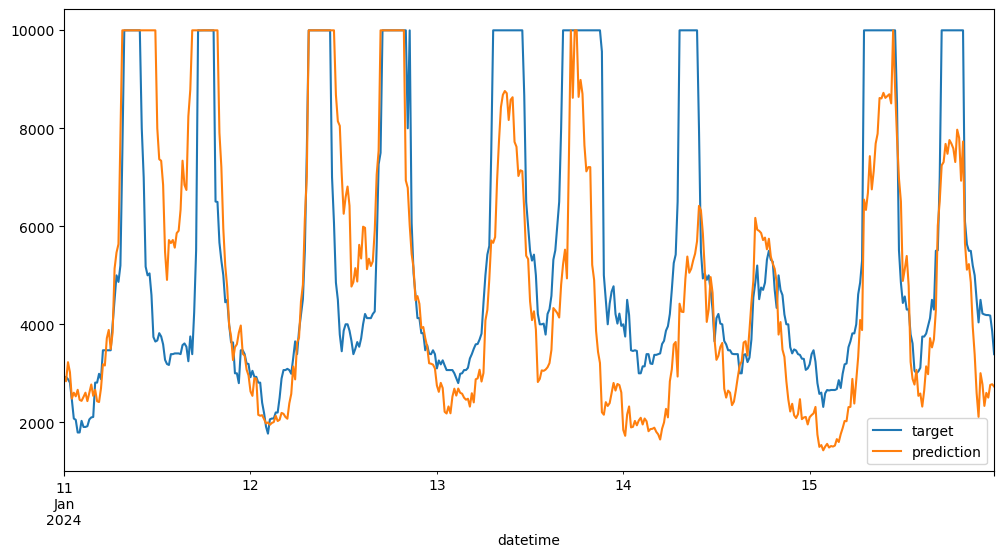

In [25]:
evaluator = ModelEvaluator(model, best_features)
evaluator.evaluate_on_data(X_test, y_test, n, market_type)

### Final Model

In [26]:
# training upto this date
training_upto = datetime.now().date().strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [27]:
# training upto this date
training_upto = datetime.now().date().strftime('%Y-%m-%d')
validation_upto = datetime.now().date().strftime('%Y-%m-%d')
X_train, y_train, X_test, y_test, X_valid, y_valid = build_model._split_data(training_data, training_upto, validation_upto)

In [30]:
model = build_model._train_model(X_train, y_train, best_params, best_features, objective = 'regression')
save_pickle(model, MODELS_PATH, f'{market_type}_forecast')